# Gold stocks and prices dynamics

In [ ]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/6d/69/9999c2d9e8a3b08dfcfc7e9259a05fb1da5f700936091d2eb4a7985c2776/tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488bb02e58694cd79d61369e85900/flatbuffers-24.3.25-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b

2024-11-25 10:50:10.373566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


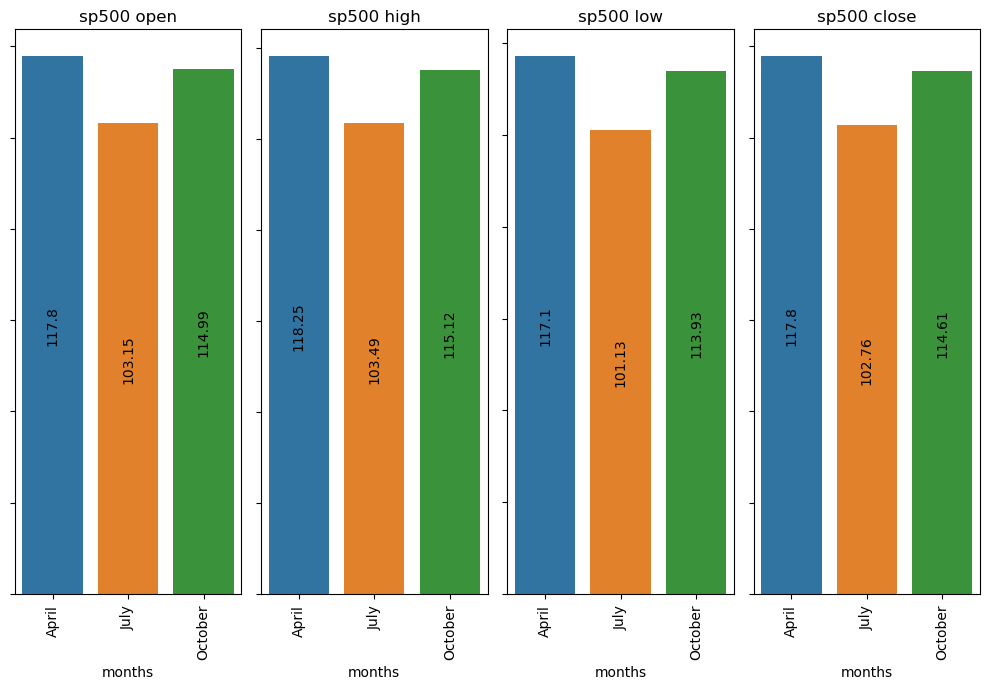

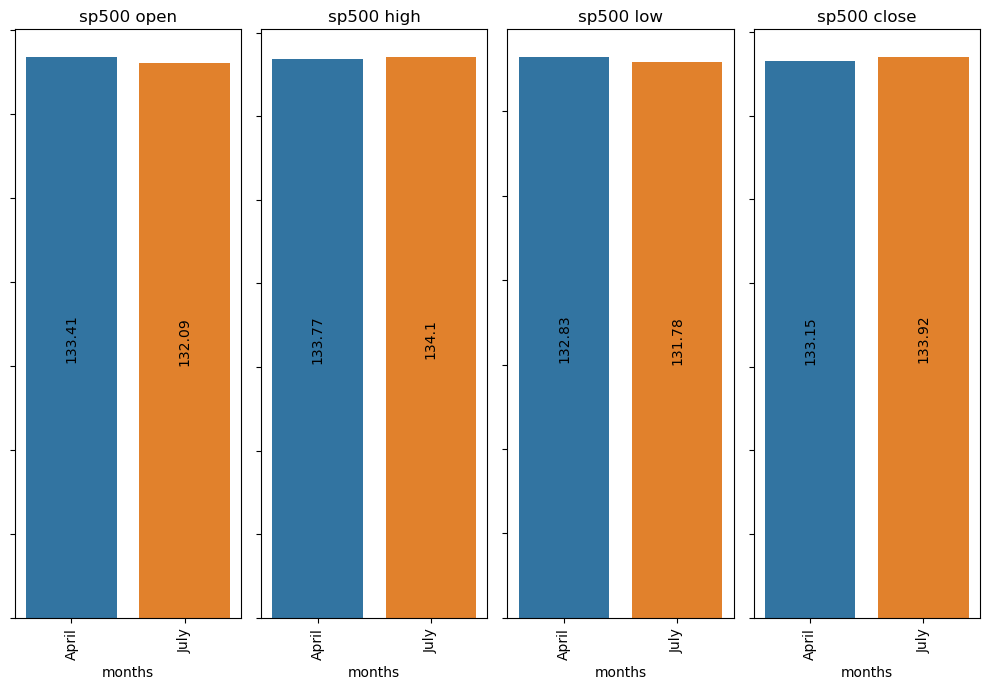

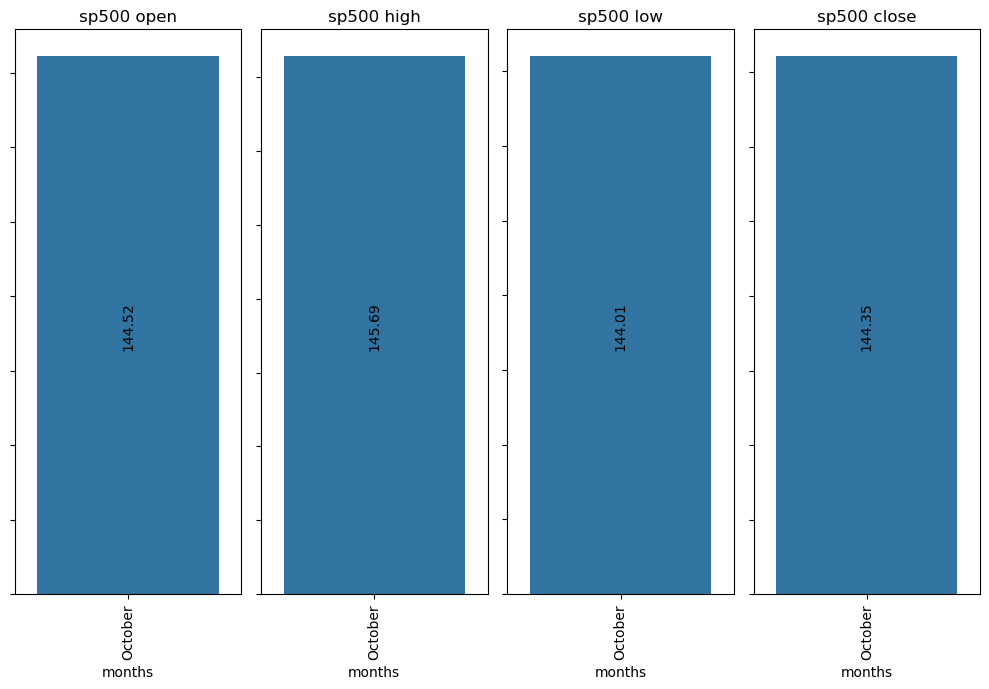

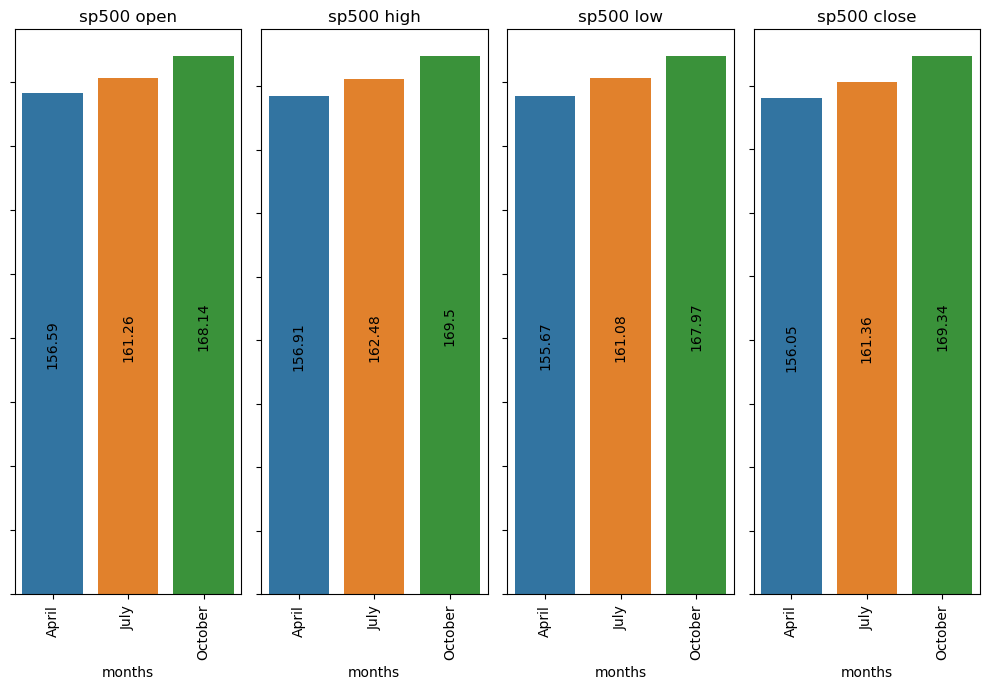

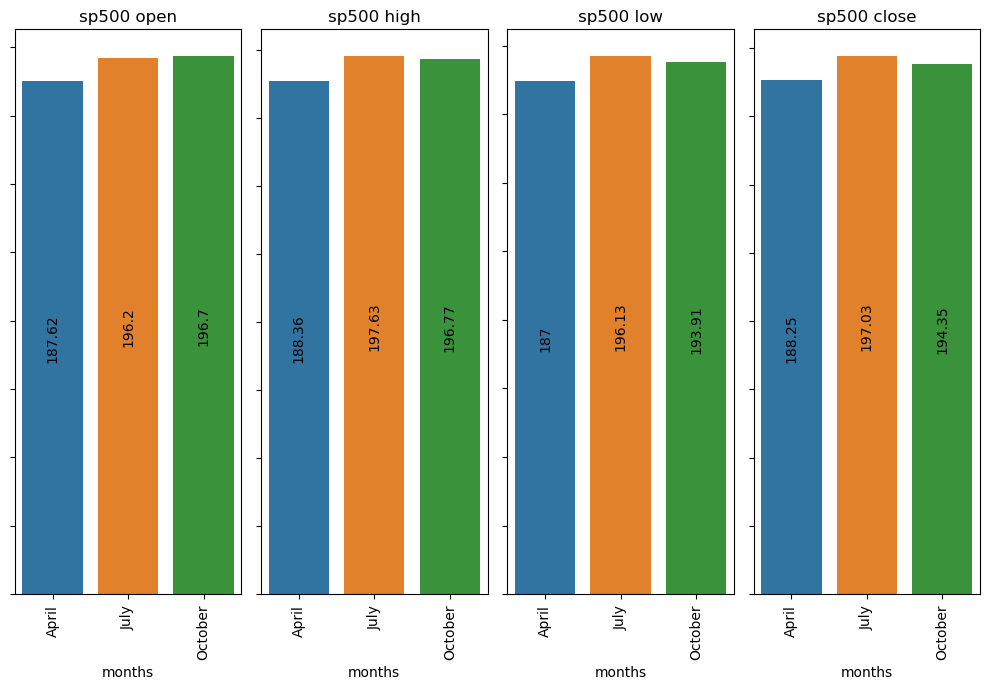

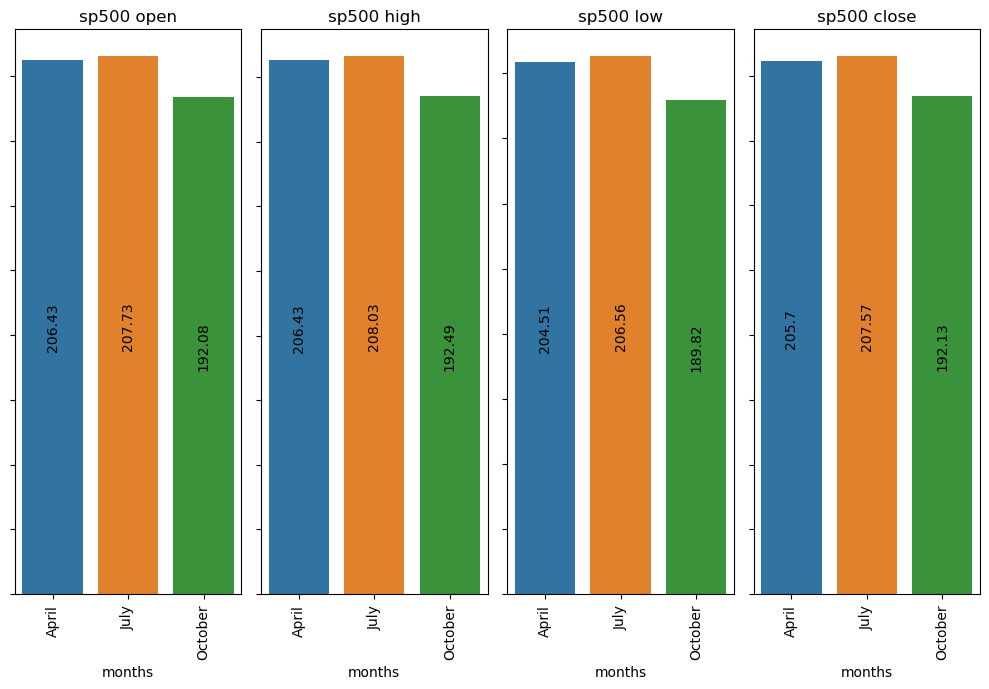

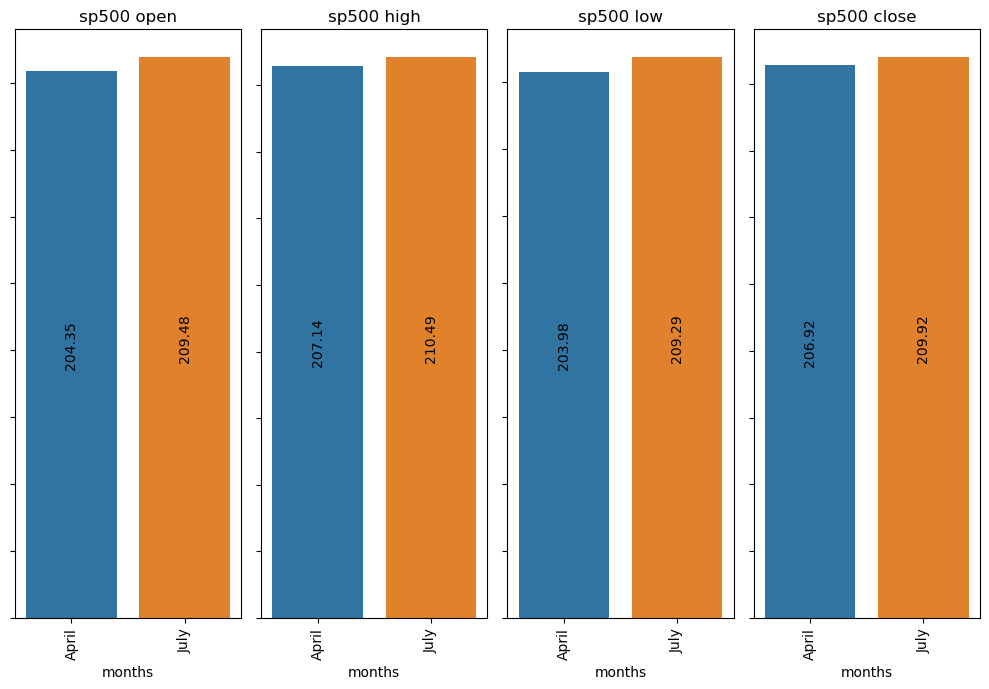

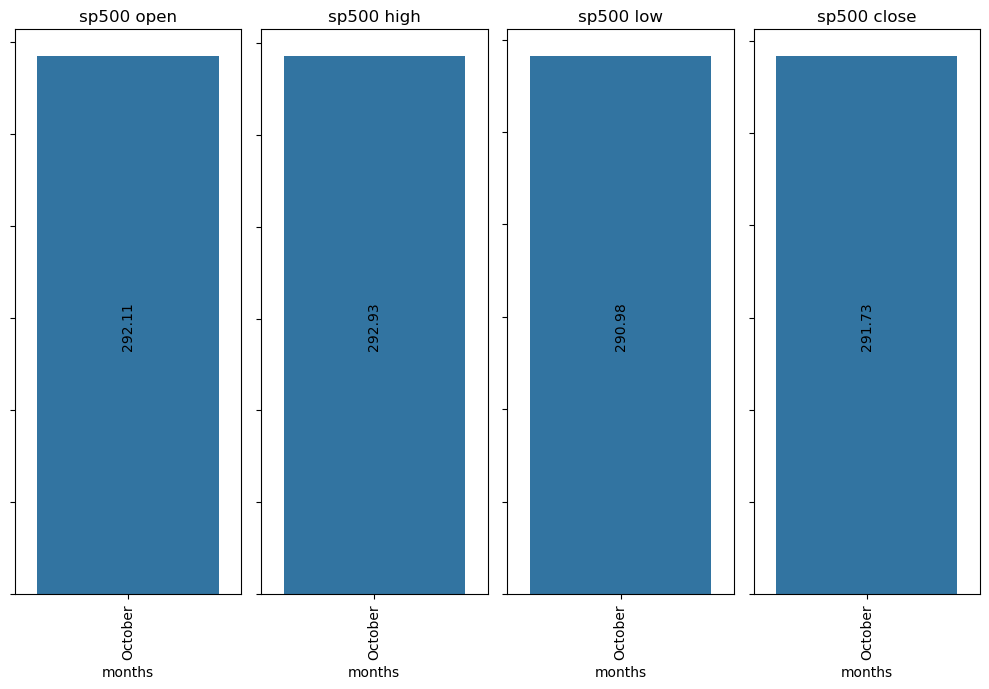

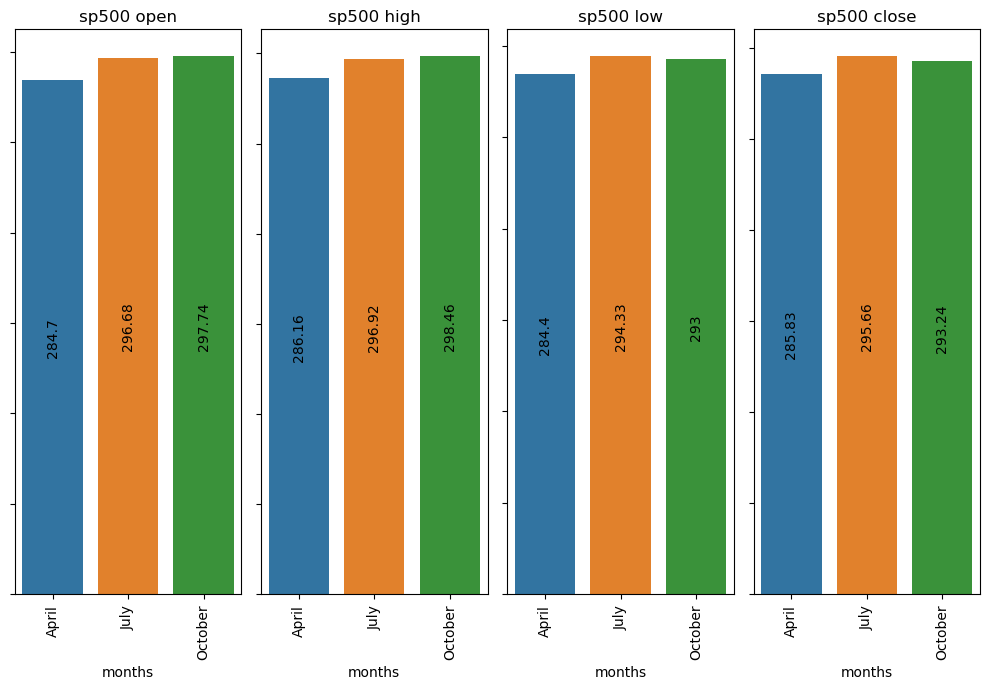

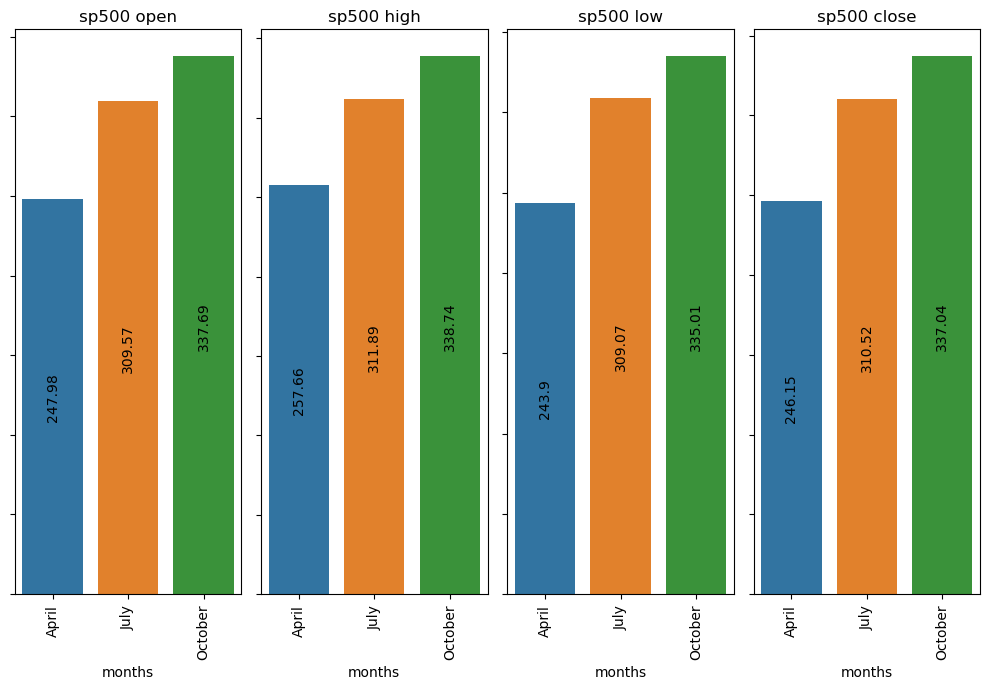

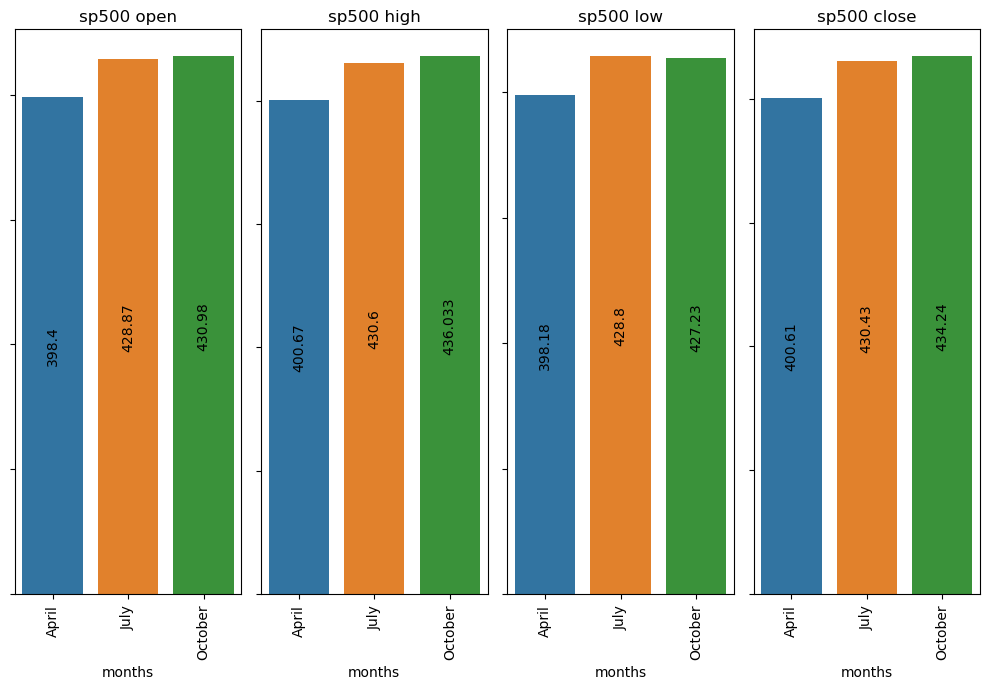

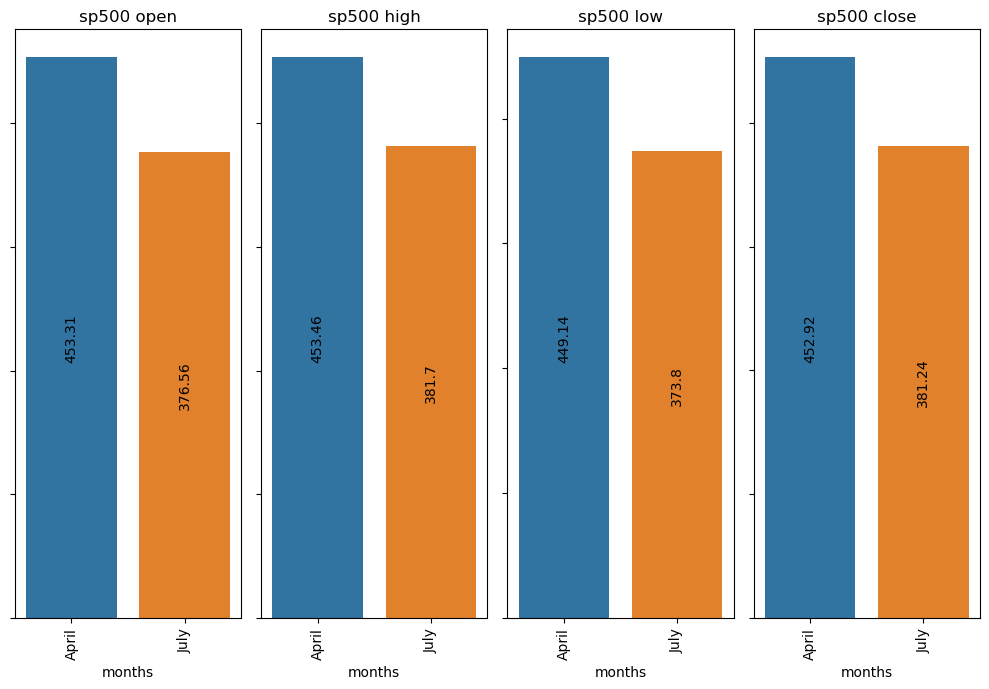

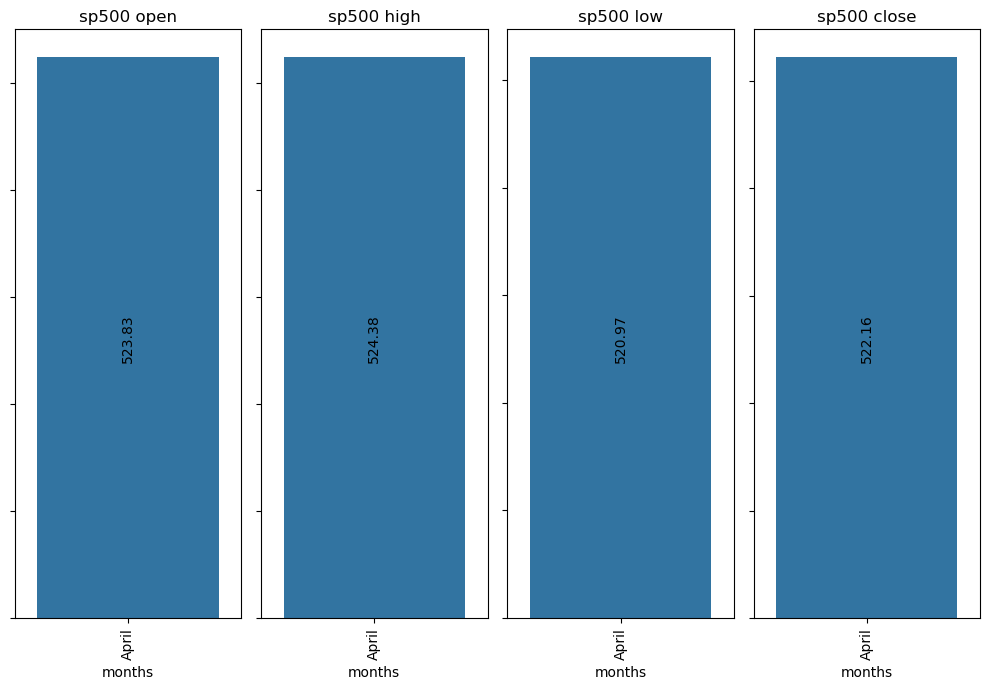

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

from IPython.core.display import display, HTML

from datetime import datetime

#df = pd.read_csv("/kaggle/input/financial-data/financial_regression.csv")
df = pd.read_csv("../financial_regression.csv")

df.dropna(inplace=True)

def convert_date(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    return [date.month, date.year]



months = ["January", "February", "March", "April",
         "May", "June", "July", "August",
         "September", "October", "November", "December"]

df["Year"] = df["date"].apply(lambda x: convert_date(x)[1])
df["Month"] = df["date"].apply(lambda x: convert_date(x)[0])

nums = df.columns[1:5].tolist()


years = df["Year"].unique()

for i in sorted(years):
    display(HTML("<h2>Monthly average stock prices for {}</h2>".format(i)))
    temp_df = df[df["Year"] == i]
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    grouped = temp_df.groupby("Month")
    for k, j in enumerate(nums):
        mean = pd.DataFrame(grouped[j].mean())
        mean = mean.sort_index(ascending=True)
        dd = {"month": [], j: []}
        for l in range(mean.shape[0]):
            dd["month"] += [months[mean.index[l]-1]]
            dd[j] += [mean.iloc[l, 0]]
        dd = pd.DataFrame(dd)
        
        sns.barplot(x=dd.iloc[:, 0].values, y=dd.iloc[:, 1].values, ax=axes[k])
        for container in axes[k].containers:
            axes[k].bar_label(container, label_type="center", rotation=90)
        axes[k].set_xticklabels(axes[k].get_xticklabels(), rotation=90)
        axes[k].set_title(j)
        axes[k].set_ylabel("")
        axes[k].set_xlabel("months")
        axes[k].set_yticklabels(())
        
    plt.tight_layout()
    plt.show()

# Data preprocessing

In [4]:
data = df[nums].copy()

cols = data.columns

for i in cols:
    dname = "Target "+i
    data[dname] = data[i].shift(-1)
    
data.dropna(inplace=True)

sc = MinMaxScaler()
scaled = sc.fit_transform(data.values)

x = []

backcandles = 1
for j in range(4):
    x.append([])
    for i in range(backcandles, scaled.shape[0]):
        x[j].append(scaled[i-backcandles:i, j])

x = np.moveaxis(x, [0], [2])

x, yi = np.array(x), np.array(scaled[backcandles:, -4:])
y = np.reshape(yi, (len(yi), 4))

split = int(len(x)*0.8)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Forecasting model architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (LSTM)              │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 4)              │           604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,604 (365.64 KB)

 Trainable params: 93,604 (365.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - loss: 0.0737 - val_loss: 0.2188
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0667 - val_loss: 0.2037
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0645 - val_loss: 0.1897
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0525 - val_loss: 0.1763
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0529 - val_loss: 0.1630
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0490 - val_loss: 0.1501
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0394 - val_loss: 0.1376
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0410 - val_loss: 0.1255
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0358 - val_loss: 0.1142
Epoch 10/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0323 - val_loss: 0.1034
Epoch 11/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0267 - val_loss: 0.0928
Epoch 12/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0234 - val_loss: 0.0823

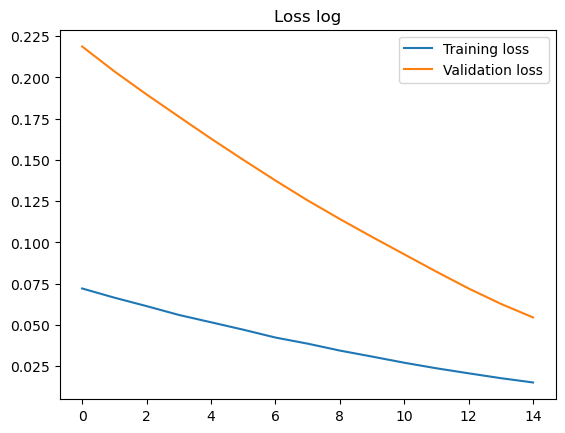

In [5]:
lstm_input = tf.keras.layers.Input(shape=(backcandles, 4), name="lstm_input")
inputs = tf.keras.layers.LSTM(150, name="first_layer")(lstm_input)
inputs = tf.keras.layers.Dense(4, name="dense_layer", activation="linear")(inputs)
model = tf.keras.models.Model(inputs=lstm_input, outputs=inputs)
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss="mse")
model.summary()

history = model.fit(x=x_train, y=y_train, batch_size=16, epochs=15, validation_split=0.1)

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.title("Loss log")
plt.show()

# Visual inspection of test results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MSE:  0.18655182918166735
r2:  -14.797113693533968


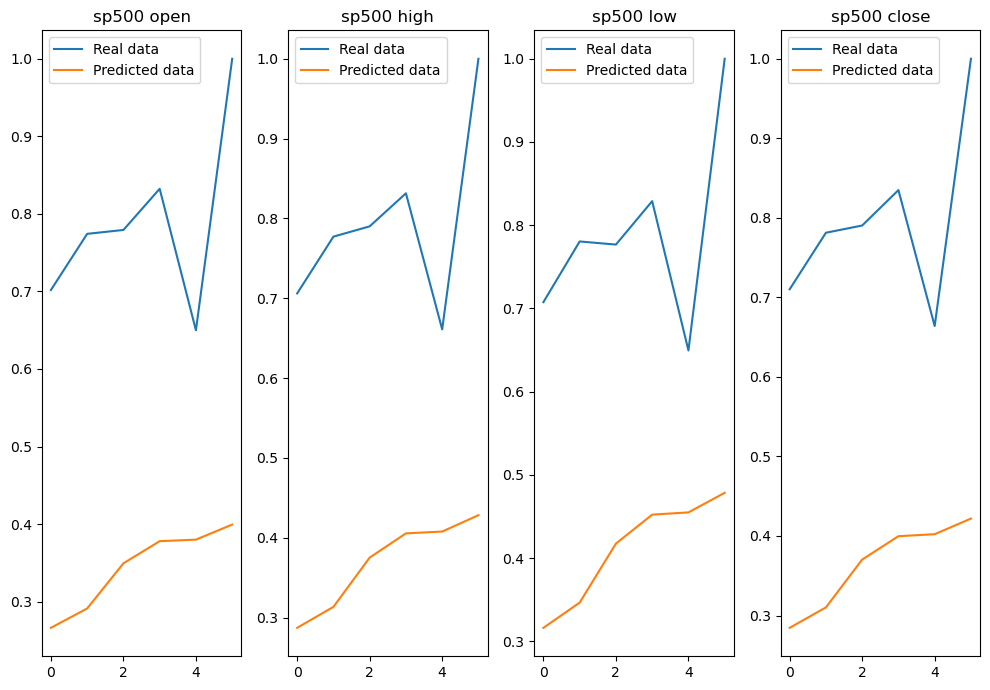

In [6]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("r2: ", r2)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
for i in range(4):
    axes[i].plot(y_test[:, i], label="Real data")
    axes[i].plot(y_pred[:, i], label="Predicted data")
    axes[i].legend()
    axes[i].set_title(nums[i])
plt.tight_layout()
plt.show()